In [2]:
import pandas as pd 
import torch
import numpy as np
from matplotlib import pyplot as plt
#from torchmetrics import JaccardIndex
import seaborn as sbn
from sklearn.metrics import roc_auc_score, accuracy_score
import time
import torchvision
import torchvision.transforms as transforms
import copy 

import sys 
sys.path.append('./src/')
from data_loading import load_tabular_data, preprocess_data, corrupt_label
from DVGS import DVGS
from DVRL import DVRL
from utils import get_corruption_scores
from NN import NN
from CNN import CNN
import similarities 
import DShap
from LOO import LOO
from sklearn.utils.class_weight import compute_class_weight
from utils import load_data, get_filtered_scores

from Estimator import Estimator

%load_ext autoreload
%autoreload 2

# Load Data 

In [3]:
x_train, y_train, x_valid, y_valid, x_test, y_test, exog_noise, endog_noise, kwargs = load_data(dataset     = 'adult', 
                                                                                                train_num   = 1000, 
                                                                                                valid_num   = 400, 
                                                                                                exog_noise  = 0., 
                                                                                                endog_noise = 0.2, 
                                                                                                lincs_dir   = './data/processed/',
                                                                                                save_dir    = './data/example/', 
                                                                                                clean_up    = True)

print('train size:', x_train.size(), y_train.size())                                                                                        
print('valid size:', x_valid.size(), y_valid.size())                                                                                        
print('test size:', x_test.size(), y_test.size())                                                                                        

train size: torch.Size([1000, 108]) torch.Size([1000, 1])
valid size: torch.Size([400, 108]) torch.Size([400, 1])
test size: torch.Size([15881, 108]) torch.Size([15881, 1])


In [4]:
classes = list(np.sort(np.unique(y_train.detach().numpy())).astype(int))
classes

[0, 1]

# Define Learning Algorithm 

In [5]:
model = NN(in_channels      = x_train.size(1), 
           out_channels     = len(classes), 
           num_layers       = 2, 
           hidden_channels  = 100, 
           norm             = True, 
           dropout          = 0.5, 
           bias             = True, 
           act              = torch.nn.Mish, 
           out_fn           = None)

In [6]:
model.state_dict().keys()

odict_keys(['f.0.weight', 'f.0.bias', 'f.4.weight', 'f.4.bias', 'f.8.weight', 'f.8.bias'])

# Data Valuation with Gradient Similarity (DVGS)

In [36]:
dvgs = DVGS(x_source         = x_train,
            y_source         = y_train, 
            x_target         = x_valid,  
            y_target         = y_valid, 
            model            = copy.deepcopy(model))

# balance class weights
class_weights = torch.tensor(compute_class_weight(class_weight='balanced', classes=classes, y=y_valid.detach().numpy().ravel()), dtype=torch.float).to('cuda')

CEL_balanced = torch.nn.CrossEntropyLoss(weight=class_weights) 
#CEL_unbalanced = torch.nn.CrossEntropyLoss() 

tic = time.time() 
run_id = dvgs.run(target_crit               = lambda x,y: CEL_balanced(x,y.squeeze(1)), 
                  source_crit               = lambda x,y: CEL_balanced(x,y.squeeze(1)),
                  num_restarts              = 3,
                  save_dir                  = '../results/',
                  similarity                = similarities.cosine_similarity(),
                  optim                     = torch.optim.SGD, 
                  lr                        = 5e-2,
                  num_epochs                = 100, 
                  compute_every             = 1, 
                  source_batch_size         = 500, 
                  target_batch_size         = 200,
                  grad_params               = None, 
                  verbose                   = True, 
                  use_cuda                  = True)

vals_dvgs = dvgs.agg(f'../results/{run_id}/')
dvgs.clean(f'../results/{run_id}/')

print()
print(f'time elapsed: {(time.time() - tic)/60:.2f} min')

using device: cuda
			 [restart: 0] iteration 99 || avg target loss: 0.38 || gradient sim. calc. elapsed / sample: 13.5 us
			 [restart: 1] iteration 99 || avg target loss: 0.39 || gradient sim. calc. elapsed / sample: 13.6 us
			 [restart: 2] iteration 99 || avg target loss: 0.38 || gradient sim. calc. elapsed / sample: 13.5 us

time elapsed: 0.18 min


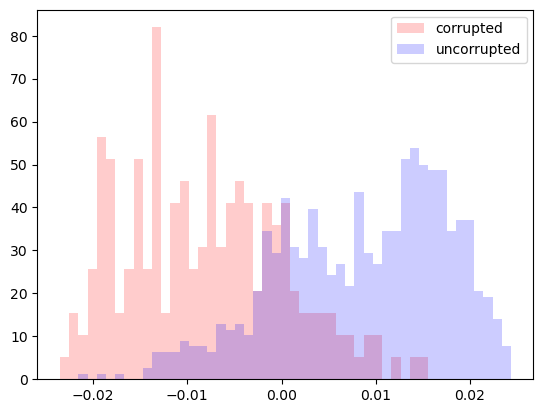

In [37]:
plt.figure() 
bins = np.linspace(vals_dvgs.min(), vals_dvgs.max(), 50)
plt.hist(vals_dvgs[endog_noise == 1], color='r', alpha=0.2, bins=bins, label='corrupted', density=True)
plt.hist(vals_dvgs[endog_noise == 0], color='b', alpha=0.2, bins=bins, label='uncorrupted', density=True)
plt.legend()
plt.show()

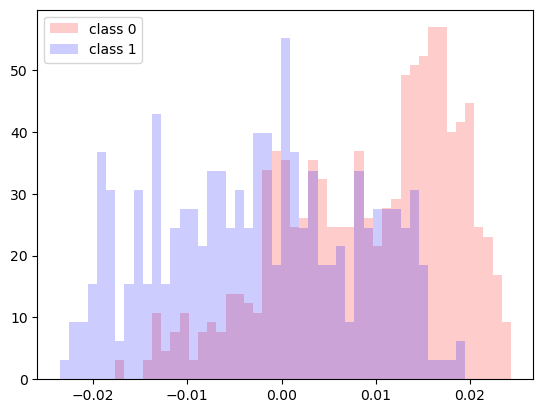

In [38]:
# data vals ~ class ? 

classes = list(np.sort(np.unique(y_train.detach().numpy()))) 
class_colors = ['r', 'b', 'g', 'y', 'c']

plt.figure() 
bins = np.linspace(vals_dvgs.min(), vals_dvgs.max(), 50)

for c in classes: 
    class_idx = (y_train == c).nonzero(as_tuple=True)[0]
    class_color = np.random.uniform(0,1,size=3)
    plt.hist(vals_dvgs[class_idx], color=class_colors[c], alpha=0.2, bins=bins, label=f'class {c}', density=True)
plt.legend()
plt.show()

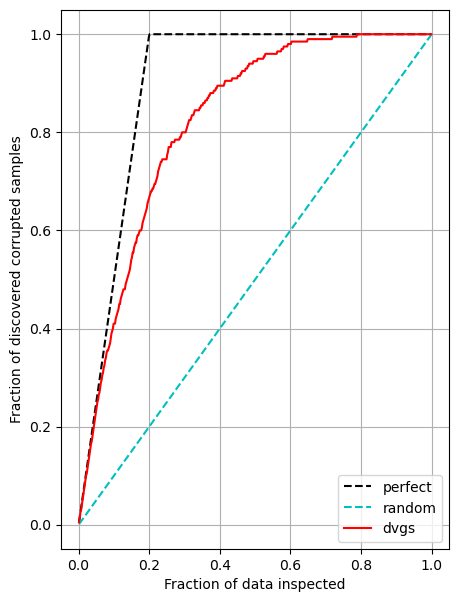

In [39]:
pk, dvgs_corr, p_perfect, p_random = get_corruption_scores(vals_dvgs, endog_noise.nonzero()[0], train_size=1000, noise_prop=0.2)

plt.figure(figsize=(5, 7))
plt.plot(pk, p_perfect, 'k--', label='perfect')
plt.plot(pk, p_random, 'c--', label='random')
plt.plot(pk, dvgs_corr, 'r-', label='dvgs')
plt.legend()
plt.ylabel('Fraction of discovered corrupted samples')
plt.xlabel('Fraction of data inspected')
plt.grid()
plt.show()

# Data Shapley (dshap)

[arxiv](https://arxiv.org/abs/1904.02868)  
[proceedings](https://proceedings.mlr.press/v97/ghorbani19c/ghorbani19c.pdf)  
[github](https://github.com/amiratag/DataShapley) 

```
@inproceedings{ghorbani2019data,
  title={Data Shapley: Equitable Valuation of Data for Machine Learning},
  author={Ghorbani, Amirata and Zou, James},
  booktitle={International Conference on Machine Learning},
  pages={2242--2251},
  year={2019}
}
```

In [ ]:
CEL = torch.nn.CrossEntropyLoss() 

dshap = DShap.DShap(model           = model, 
                    crit            = lambda x,y: CEL(x,y.squeeze(1).type(torch.long)),
                    x_train         = x_train,
                    y_train         = y_train,
                    x_valid         = x_valid,
                    y_valid         = y_valid,
                    perf_metric     = lambda y, yhat: roc_auc_score(y, yhat[:, 1]),
                    epochs          = 100,
                    tol             = 0.03,
                    optim           = torch.optim.Adam,
                    lr              = 1e-3,
                    verbose         = True)

tic = time.time() 
vals_shap = dshap.TMC(max_iterations=500, min_iterations=50, use_cuda=True, T=5, stopping_criteria=0.999)

print()
print(f'time elapsed: {(time.time() - tic)/60:.2f} min')

v0 (null model): 0.5149
vD (all data): 0.8685

starting Data Shapley TMC...
iter: 119 || max j: 371 || max vj: 0.8490 || rank_corr: 0.9990
MC stopping criteria met. running avg rank correlation: 0.9990

time elapsed: 347.52 min


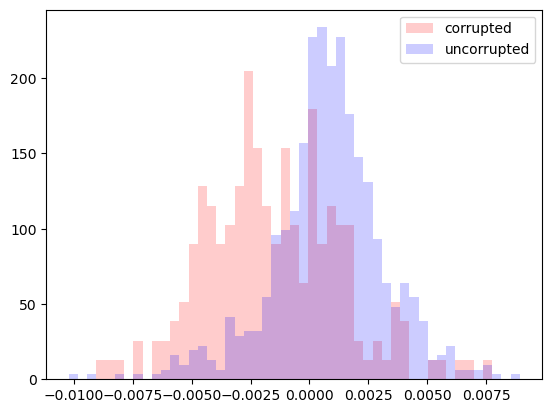

In [ ]:
plt.figure() 
bins = np.linspace(vals_shap.min(), vals_shap.max(), 50)
plt.hist(vals_shap[endog_noise == 1], color='r', alpha=0.2, bins=bins, label='corrupted', density=True)
plt.hist(vals_shap[endog_noise == 0], color='b', alpha=0.2, bins=bins, label='uncorrupted', density=True)
plt.legend()
plt.show()

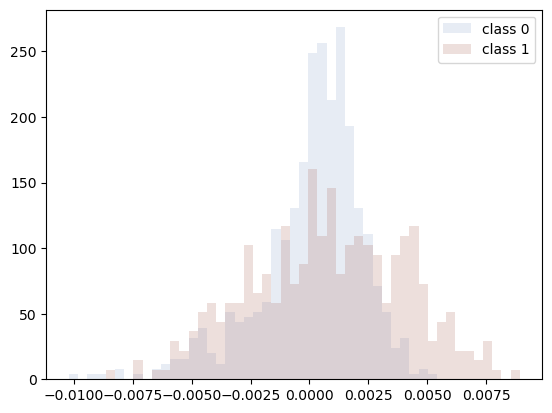

In [ ]:
# data vals ~ class ? 

classes = list(np.sort(np.unique(y_train.detach().numpy()))) 

plt.figure() 
bins = np.linspace(vals_shap.min(), vals_shap.max(), 50)

for c in classes: 
    class_idx = (y_train == c).nonzero(as_tuple=True)[0]
    class_color = np.random.uniform(0,1,size=4)
    plt.hist(vals_shap[class_idx], color=class_color, alpha=0.2, bins=bins, label=f'class {c}', density=True)
plt.legend()
plt.show()

(1000,)


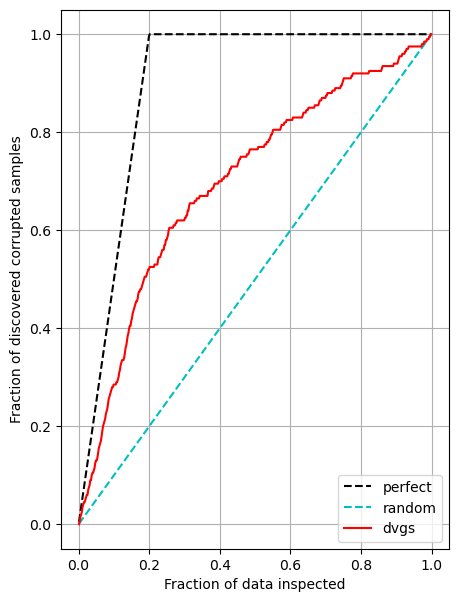

In [ ]:
pk, shap_corr, p_perfect, p_random = get_corruption_scores(vals_shap, endog_noise.nonzero()[0], train_size=1000, noise_prop=0.2)

plt.figure(figsize=(5, 7))
plt.plot(pk, p_perfect, 'k--', label='perfect')
plt.plot(pk, p_random, 'c--', label='random')
plt.plot(pk, shap_corr, 'r-', label='dvgs')
plt.legend()
plt.ylabel('Fraction of discovered corrupted samples')
plt.xlabel('Fraction of data inspected')
plt.grid(b=None)
plt.show()

# Leave-one-out (LOO)



In [ ]:
CEL = torch.nn.CrossEntropyLoss() 
crit = lambda x,y: CEL(x,y.squeeze(1).type(torch.long)) 
metric = lambda y,yhat: roc_auc_score(y, yhat[:, 1])  

loo = LOO(x_train           = x_train,
          y_train           = y_train,
          x_valid           = x_valid,
          y_valid           = y_valid,
          model             = model,
          metric            = metric,
          crit              = crit, 
          optim             = torch.optim.Adam, 
          epochs            = 200, 
          lr                = 1e-4,
          batch_size        = 250, 
          use_cuda          = True, 
          verbose           = True, 
          baseline_repl     = 10,
          n_repl            = 1)

print()  

loo_values = loo.run()
vals_loo = np.array(loo_values)

baseline performance: 0.857 +/- 0.001



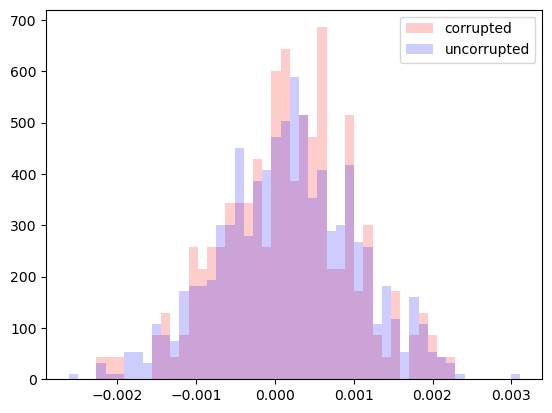

In [ ]:
plt.figure() 
bins = np.linspace(vals_loo.min(), vals_loo.max(), 50)
plt.hist(vals_loo[endog_noise == 1], color='r', alpha=0.2, bins=bins, label='corrupted', density=True)
plt.hist(vals_loo[endog_noise == 0], color='b', alpha=0.2, bins=bins, label='uncorrupted', density=True)
plt.legend()
plt.show()

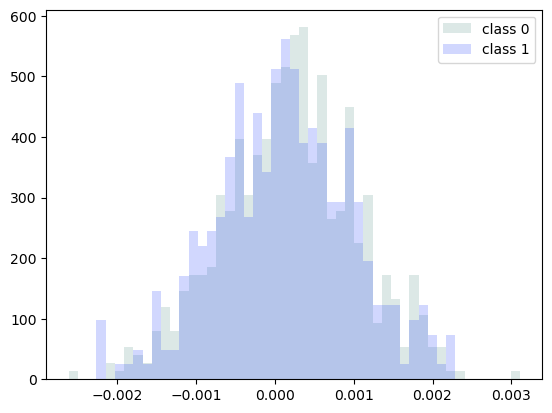

In [ ]:
# data vals ~ class ? 

classes = list(np.sort(np.unique(y_train.detach().numpy()))) 

plt.figure() 
bins = np.linspace(vals_loo.min(), vals_loo.max(), 50)

for c in classes: 
    class_idx = (y_train == c).nonzero(as_tuple=True)[0]
    class_color = np.random.uniform(0,1,size=4)
    plt.hist(vals_loo[class_idx], color=class_color, alpha=0.2, bins=bins, label=f'class {c}', density=True)
plt.legend()
plt.show()

(1000,)


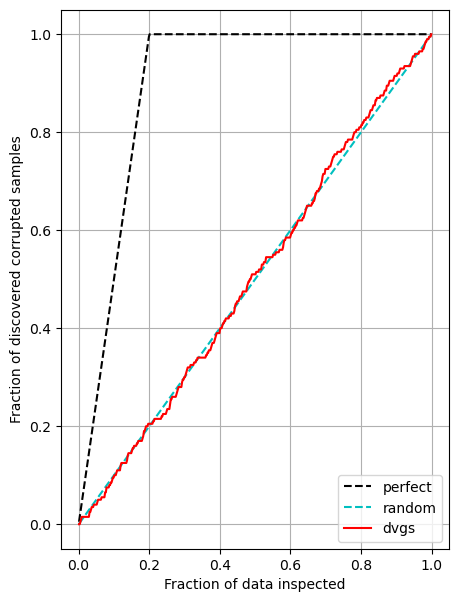

In [ ]:
pk, loo_corr, p_perfect, p_random = get_corruption_scores(vals_loo, endog_noise.nonzero()[0], train_size=1000, noise_prop=0.2)

plt.figure(figsize=(5, 7))
plt.plot(pk, p_perfect, 'k--', label='perfect')
plt.plot(pk, p_random, 'c--', label='random')
plt.plot(pk, loo_corr, 'r-', label='dvgs')
plt.legend()
plt.ylabel('Fraction of discovered corrupted samples')
plt.xlabel('Fraction of data inspected')
plt.grid(b=None)
plt.show()

# Data Valuation with Reinforcement Learning (DVRL)



In [25]:
#pred = LogisticRegression(108, 2) 

pred = copy.deepcopy(model) 
#pred.reset_parameters()

estimator = Estimator(xin               = 108, 
                      yin               = 4, 
                      y_cat_dim         = 10, 
                      num_layers        = 5, 
                      hidden_channels   = 100, 
                      norm              = False, 
                      dropout           = 0., 
                      act               = torch.nn.ReLU)

dvrl = DVRL(x_train             = x_train,
            y_train             = y_train,
            x_valid             = x_valid,
            y_valid             = y_valid,
            predictor           = pred, 
            estimator           = estimator, 
            problem             = 'classification',
            include_marginal    = True)

dvrl_run = { 
                "perf_metric"            : 'auroc', 
                "crit_pred"              : lambda yhat,y: torch.nn.functional.cross_entropy(yhat, y.squeeze(1)), 
                "outer_iter"             : 500, 
                "inner_iter"             : 100, 
                "outer_batch"            : 1000, 
                "inner_batch"            : 256, 
                "estim_lr"               : 1e-2, 
                "pred_lr"                : 1e-3, 
                "fix_baseline"           : True,
                "use_cuda"               : True,
            }

print()

# pretraining...
#dvrl.fit(dvrl.predictor, dvrl.x_train, dvrl.y_train, crit=lambda x,y: CEL(x,y.squeeze(1).type(torch.long)), batch_size=256, lr=1e-4, epochs=500, use_cuda=True)

tic = time.time() 
vals_dvrl = dvrl.run(**dvrl_run, noise_labels=endog_noise)

vals_dvrl = vals_dvrl.detach().numpy().ravel()

print()
print(f'time elapsed: {(time.time() - tic)/60:.2f} min')      


pretraining `ori_model` and `val_model` 
[0.8298983625070583, 0.8337450592885376, 0.8359330886504799]
4/4
outer iteration: 499 || reward: 0.0040 || dvrl perf: 0.8372 || baseline: 0.8332 || noise auc: 0.84|| crpt/tot: 111/628 [0.18] || epoch elapsed: 0.3 ss

time elapsed: 2.31 min


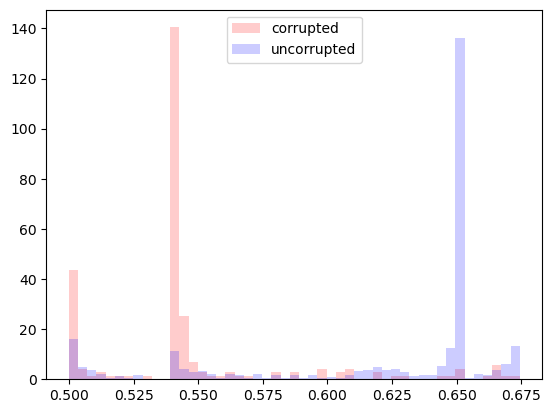

In [26]:
plt.figure() 
bins = np.linspace(vals_dvrl.min(), vals_dvrl.max(), 50)
plt.hist(vals_dvrl[endog_noise == 1], color='r', alpha=0.2, bins=bins, label='corrupted', density=True)
plt.hist(vals_dvrl[endog_noise == 0], color='b', alpha=0.2, bins=bins, label='uncorrupted', density=True)
plt.legend()
plt.show()

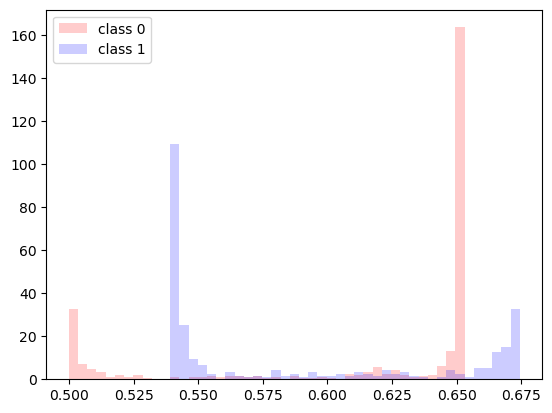

In [28]:
# data vals ~ class ? 

classes = list(np.sort(np.unique(y_train.detach().numpy()))) 
class_colors = ['r', 'b', 'g', 'y', 'c']

plt.figure() 
bins = np.linspace(vals_dvrl.min(), vals_dvrl.max(), 50)

for c in classes: 
    class_idx = (y_train == c).nonzero(as_tuple=True)[0]
    class_color = np.random.uniform(0,1,size=4)
    plt.hist(vals_dvrl[class_idx], color=class_colors[c], alpha=0.2, bins=bins, label=f'class {c}', density=True)
plt.legend()
plt.show()

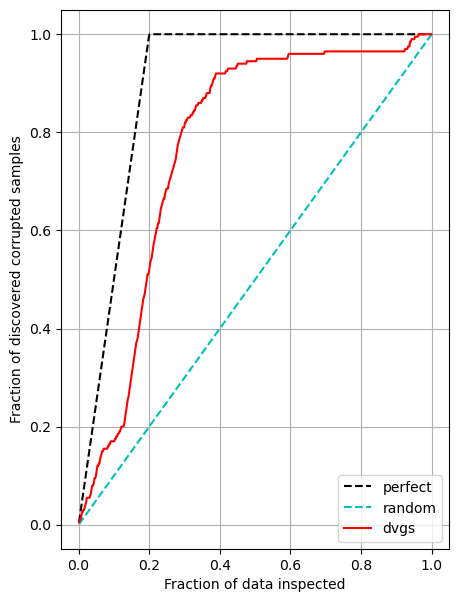

In [31]:
pk, dvrl_corr, p_perfect, p_random = get_corruption_scores(vals_dvrl, endog_noise.nonzero()[0], train_size=1000, noise_prop=0.2)

plt.figure(figsize=(5, 7))
plt.plot(pk, p_perfect, 'k--', label='perfect')
plt.plot(pk, p_random, 'c--', label='random')
plt.plot(pk, dvrl_corr, 'r-', label='dvgs')
plt.legend()
plt.ylabel('Fraction of discovered corrupted samples')
plt.xlabel('Fraction of data inspected')
plt.grid()
plt.show()